In [1]:
from pathlib import Path
from scipy.io import wavfile
import scipy.signal
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [2]:
val_list_file = Path('..') / 'data' / 'train' / 'validation_list.txt'
test_list_file = Path('..') / 'data' / 'train' / 'testing_list.txt'

with open(val_list_file, 'r') as file:
    set_val_all = set(line.strip().replace('/', '\\') for line in file)
with open(test_list_file, 'r') as file:
    set_test_all = set(line.strip().replace('/', '\\') for line in file)

    
root_folder = Path('..') / 'data' / 'train' / 'audio'

lines = []

set_all = set()

for path in root_folder.rglob('*'):
    if '_background_noise_' not in path.parts and path.is_file():
        set_all.add(str(path.relative_to(root_folder)))
        
set_train_all = set_all - set_val_all - set_test_all

folders_main = ['on', 'four', 'yes', 'nine', 'three', 'no', 'stop', 'five', 'right', 'down', 'one', 'eight', 'off', 'zero', 'two', 'up', 'six', 'go', 'left', 'seven']
print('Main folders:', folders_main)

set_not_main = set()
folders_main_ser = pd.Series(list(folders_main))

for path in root_folder.rglob('*'):
    if not folders_main_ser.isin(path.parts).any() and path.is_file():
        set_not_main.add(str(path.relative_to(root_folder)))
        
set_main = set_all - set_not_main        
set_val_main = set_val_all - set_not_main
set_test_main = set_test_all - set_not_main
set_train_main = set_train_all - set_not_main
        
print(f'Files (not including background noise): {len(set_all)}, main {len(set_main)},  not main {len(set_not_main)}')
print(f'Main {len(set_main)}, train {len(set_train_main)}, val {len(set_val_main)}, test {len(set_test_main)}')

Main folders: ['on', 'four', 'yes', 'nine', 'three', 'no', 'stop', 'five', 'right', 'down', 'one', 'eight', 'off', 'zero', 'two', 'up', 'six', 'go', 'left', 'seven']
Files (not including background noise): 64721, main 47348,  not main 17380
Main 47348, train 37158, val 5071, test 5119


In [3]:
root_folder = Path('..') / 'data' / 'train' / 'audio'

In [4]:
# sample_rates = set()

# for f in tqdm(set_all - set_not_main):
# #     print('Reading', root_folder / f)
#     sample_rate, data = wavfile.read(root_folder / f)
#     sample_rates.add(sample_rate)
# sample_rates

In [5]:
folder = 'yes'
folder_main_train_files = np.array(list(set_train_main))[pd.Series(list(set_train_main)).str.contains(folder).values]
folder_main_train_files.shape

(1860,)

In [6]:
sample_rate, data = wavfile.read(root_folder / folder_main_train_files[0])

sample_rate, data.shape, data.dtype

(16000, (16000,), dtype('int16'))

In [7]:
pd.Series(data).describe()

count    16000.000000
mean        -0.656875
std       1061.268811
min      -8260.000000
25%       -143.000000
50%         -2.000000
75%        145.000000
max       7375.000000
dtype: float64

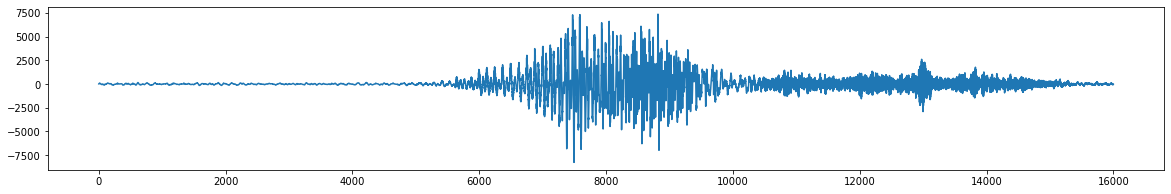

In [8]:
plt.figure(figsize=(20, 3))
plt.plot(data);

In [9]:
yes_all_list = []
lengths = Counter()

for f in tqdm(folder_main_train_files):
    _, data = wavfile.read(root_folder / f)
    yes_all_list.append(data)
    lengths.update([len(data)])
lengths

  0%|          | 0/1860 [00:00<?, ?it/s]

Counter({16000: 1686,
         15702: 23,
         15604: 10,
         14118: 11,
         14336: 15,
         11947: 1,
         11146: 5,
         9558: 3,
         10240: 2,
         13375: 12,
         11606: 8,
         11889: 7,
         12971: 8,
         12288: 8,
         12632: 6,
         10403: 4,
         14861: 17,
         13654: 10,
         15019: 9,
         8022: 1,
         10923: 6,
         8174: 2,
         8875: 1,
         15360: 2,
         9660: 1,
         9387: 1,
         8917: 1})

In [10]:
yes_train_16000_list = []

for f in tqdm(folder_main_train_files):
    _, data = wavfile.read(root_folder / f)
    if len(data) == 16000:
        yes_train_16000_list.append(data)

  0%|          | 0/1860 [00:00<?, ?it/s]

In [11]:
yes_train_16000_df = np.stack(yes_train_16000_list)
yes_train_16000_df.shape

(1686, 16000)

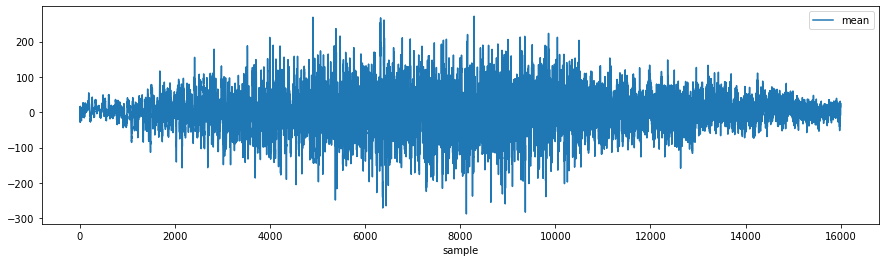

In [12]:
plt.figure(figsize=(15,4))
plt.plot(yes_train_16000_df.mean(axis=0), label='mean')
plt.xlabel('sample')
plt.legend()
plt.show()

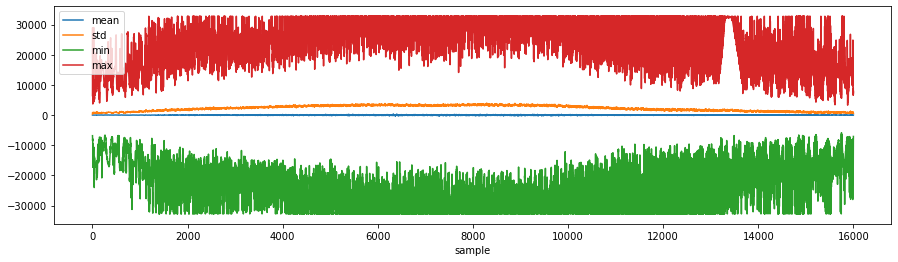

In [13]:
plt.figure(figsize=(15,4))
plt.plot(yes_train_16000_df.mean(axis=0), label='mean')
plt.plot(yes_train_16000_df.std(axis=0), label='std')
plt.plot(yes_train_16000_df.min(axis=0), label='min')
plt.plot(yes_train_16000_df.max(axis=0), label='max')
plt.xlabel('sample')
plt.legend()
plt.show()

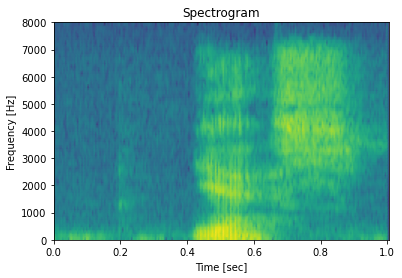

In [14]:
# Compute the STFT
frequencies, times, Zxx = scipy.signal.stft(data, fs=sample_rate, nperseg=128, noverlap=56)

# Note: nperseg (number of samples per segment) and noverlap (number of samples to overlap) 
# can be adjusted according to your needs

# Compute the magnitude (absolute value) of the STFT complex numbers
Zxx = np.abs(Zxx)

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Zxx), shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [15]:
all_freq_list = []
all_times_list = []
all_Zxx_list = []

for i in tqdm(range(len(yes_train_16000_df))):
    frequencies, times, Zxx = scipy.signal.stft(yes_train_16000_df[i], fs=sample_rate, nperseg=128, noverlap=56)
    Zxx = np.abs(Zxx)
    all_freq_list.append(frequencies)
    all_times_list.append(times)
    all_Zxx_list.append(Zxx)

  0%|          | 0/1686 [00:00<?, ?it/s]

In [16]:
all_freq_df = np.stack(all_freq_list)
all_freq_df.shape

(1686, 65)

In [17]:
all_times_df = np.stack(all_times_list)
all_times_df.shape

(1686, 224)

In [18]:
all_Zxx_df = np.stack(all_Zxx_list)
all_Zxx_df.shape

(1686, 65, 224)

In [19]:
assert (all_freq_df.std(axis=0) == 0).all()

In [20]:
assert np.isclose(all_times_df.std(axis=0), 0, atol=.001).all()

In [21]:
Zxx_means = all_Zxx_df.mean(axis=0)
Zxx_means.shape

(65, 224)

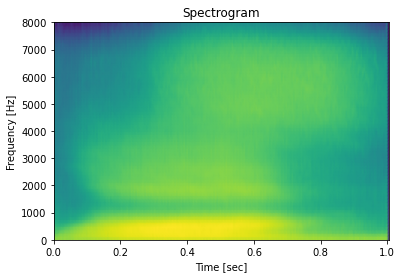

In [22]:
plt.pcolormesh(times, frequencies, 10 * np.log10(Zxx_means), shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [23]:
# Zero Crossing Rate